In [1]:
from tensorflow import keras
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import os
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()
    print("Adf")
    # Resize training images
    # X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    # X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])
    print("asdasd")
    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

X_train = np.average(X_train, axis=3)
X_test = np.average(X_test, axis=3)

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Adf
asdasd


Model: "inception_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 1)       0         
_________________________________________________________________
reshape (Reshape)            (None, 224, 224, 1)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


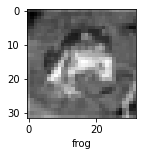

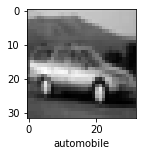

In [2]:

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index], cmap='gray')
    plt.xlabel(classes[np.argmax([y[index]])])

plot_sample(X_train, y_train, 0)
plot_sample(X_train, y_train, 4)

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

input_layer = Input(shape=(32, 32, 1))
resized_image = tf.keras.layers.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=False)(input_layer)
reshaped_image = tf.keras.layers.Reshape((224, 224, 1))(resized_image)

model = Model(input_layer, reshaped_image, name='inception_v1')
model.summary()

In [3]:
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(reshaped_image)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')

model.summary()



Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 224, 224, 1)  0           resizing[0][0]                   
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 3200        reshape[0][0]                    
_______________________________________________________________________________________

In [4]:
epochs = 5
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)


# history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=32, callbacks=[cp_callback, lr_sc])



# # load model from saved file
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# print(latest)

# # Create a new model instance
# model = ()

# # Load the previously saved weights
# model = Model(input_layer, [x, x1, x2], name='inception_v1')

# model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])
# # Re-evaluate the model
# model.evaluate(X_test, y_test, verbose=2)


In [5]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=32, callbacks=[lr_sc], verbose=2)

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1563/1563 - 394s - loss: 3.6985 - output_loss: 2.3154 - auxilliary_output_1_loss: 2.3045 - auxilliary_output_2_loss: 2.3058 - output_accuracy: 0.1006 - auxilliary_output_1_accuracy: 0.1010 - auxilliary_output_2_accuracy: 0.1001 - val_loss: 3.6849 - val_output_loss: 2.3032 - val_auxilliary_output_1_loss: 2.3028 - val_auxilliary_output_2_loss: 2.3028 - val_output_accuracy: 0.1000 - val_auxilliary_output_1_accuracy: 0.1000 - val_auxilliary_output_2_accuracy: 0.1000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
1563/1563 - 406s - loss: 3.6853 - output_loss: 2.3035 - auxilliary_output_1_loss: 2.3030 - auxilliary_output_2_loss: 2.3030 - output_accuracy: 0.0974 - auxilliary_output_1_accuracy: 0.0999 - auxilliary_output_2_accuracy: 0.0972 - val_loss: 3.6852 - val_output_loss: 2.3035 - val_auxilliary_output_1_loss: 2.3027 - val_auxilliary_output_2_loss: 2.3028 - val_output_accuracy: 0.100

In [6]:
model.save('GoogleNet_model.h5')

In [7]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [8]:
# imports

from keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

# opening and store file in a variable

json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()

# use Keras model_from_json to make a loaded model

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("model.h5")
print("Loaded Model from disk")

# compile and evaluate loaded model
loaded_model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])


Loaded Model from disk


In [9]:
loaded_model.evaluate(X_test, y_test, verbose=2)

313/313 - 17s - loss: 6.4373 - output_loss: 2.2171 - auxilliary_output_1_loss: 2.1029 - auxilliary_output_2_loss: 2.1172 - output_accuracy: 0.1717 - auxilliary_output_1_accuracy: 0.2645 - auxilliary_output_2_accuracy: 0.2279


[6.437264919281006,
 2.2170822620391846,
 2.1029489040374756,
 2.1172335147857666,
 0.17170000076293945,
 0.2644999921321869,
 0.22789999842643738]

In [10]:
pred = loaded_model.predict(X_test)

In [11]:
pred = np.array(pred)
pred[0].shape

(10000, 10)

In [12]:
x = cv2.imread('frog1.png', cv2.IMREAD_GRAYSCALE)
# print(x)
# x = np.invert(x)
res = cv2.resize(x, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
res = res.reshape(1,32,32,1)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
